# Visualization function

In [28]:
import time
from sklearn import manifold
from sklearn.decomposition import PCA
import pandas as pd


# TSNE visualization of data with categorical colorization
def TSNE_visu(_data, _category_label, _ax):
    # Create TSNE decomposer
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200, random_state=42)
    # Decompose bag of words features using TNSE
    X_tsne = tsne.fit_transform(_data)

    # Data visualization
    scatter = _ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                          c=_category_label, cmap='Set1')
    _ax.legend(handles=scatter.legend_elements()[0], labels=list(
        set(_category_label)), loc="best", title="Categories", fontsize=15, title_fontsize=15)
    return

def PCA_visu(_data, _category_label, _ax):
    # Create TSNE decomposer
    pca = PCA(n_components=2, svd_solver='full')
    # Decompose bag of words features using TNSE
    X_pca = pca.fit_transform(_data)

    # Data visualization
    scatter = _ax.scatter(X_pca[:, 0], X_pca[:, 1],
                          c=_category_label, cmap='Set1')
    _ax.legend(handles=scatter.legend_elements()[0], labels=list(
        set(_category_label)), loc="best", title="Categories", fontsize=15, title_fontsize=15)
    return


# Load data

In [29]:
import tensorflow as tf

batch_size = 32
img_height = 224
img_width = 224

data_dir = "Flipkart/Images"

# Charge articles images and categories
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1050 files belonging to 7 classes.


2022-06-02 19:57:24.371667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Images features visualization with ResNet50 model

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from tensorflow.keras.applications import ResNet50
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Create base_model classifier
base_model = ResNet50(weights="imagenet", include_top=False,
              input_shape=(img_height, img_width, 3))
base_model.trainable = False

# Create new layer to flatten the output data
flat1 = tf.keras.layers.Flatten()(base_model.layers[-1].output)

# Define new model
model = tf.keras.Model(inputs=base_model.inputs, outputs=flat1)

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Get output features number
for images, labels in val_ds:
    for i in range(1,len(images)):
        image = tf.keras.utils.img_to_array(images[i]).copy()
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        features_nb = len(model.predict(image)[0])
        break

# Create features and labels mat
features_mat = np.empty((1050,features_nb))
labels_list = []

# Fill features and labels mat
cpt=0
for images, labels in val_ds:
    for i in range(0,len(images)):
        # convert the image pixels to a numpy array
        image = tf.keras.utils.img_to_array(images[i]).copy()
        image = tf.cast(image, tf.float32)
        # prepare the image for the resnet50 model
        image = tf.keras.applications.resnet50.preprocess_input(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # predict the probability across all output classes
        features_mat[cpt,:] = model.predict(image)[0]
        labels_list.append(int(labels[i]))
        cpt=cpt+1

labels_df = pd.DataFrame(labels_list)
print('silouhette score : ', silhouette_score(features_mat, labels_df.values.ravel()))

1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 125ms/step
silouhette score :  0.027533509187169673


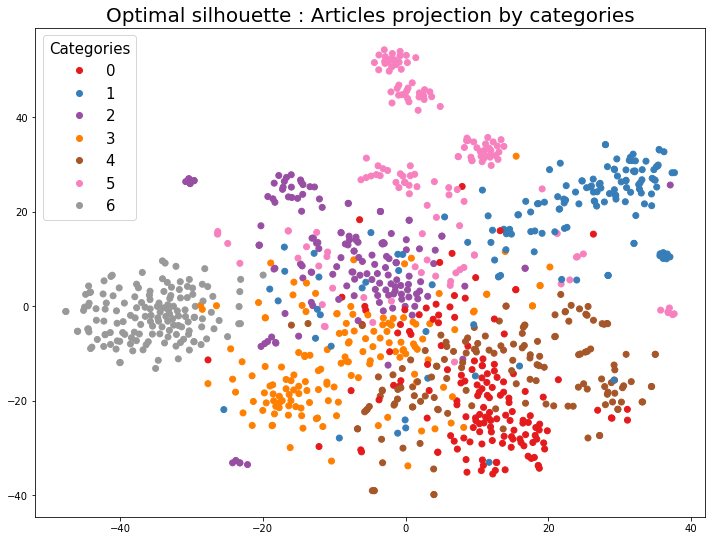

(1050, 100352)


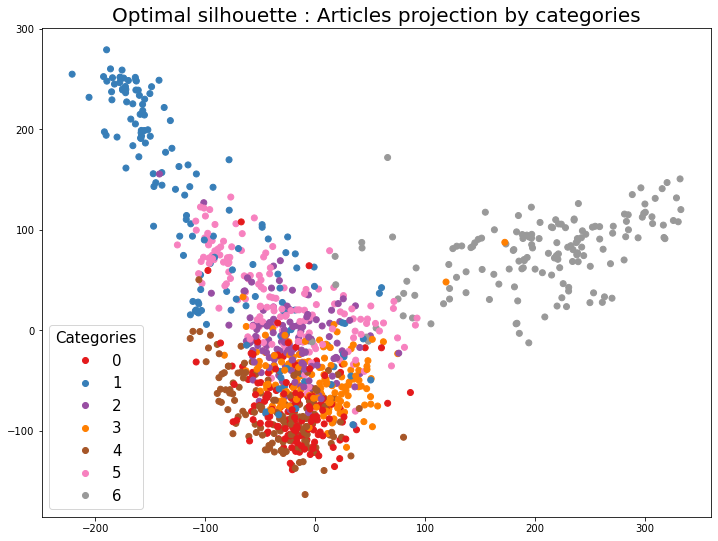

In [32]:
# Display TSNE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
TSNE_visu(features_mat, labels_df.values.ravel(), ax)
ax.set_title('Optimal silhouette : Articles projection by categories', fontsize=20)
plt.show()

# Display PCA
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
PCA_visu(features_mat, labels_df.values.ravel(), ax)
ax.set_title('Optimal silhouette : Articles projection by categories', fontsize=20)
plt.show()

# Images features visualization with VGG16 model

In [5]:
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from sklearn.metrics import silhouette_score


# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model = VGG16(weights="imagenet", include_top=False,
              input_shape=(img_height, img_width, 3))
base_model.trainable = False

# add new classifier layers
flat1 = tf.keras.layers.Flatten()(base_model.layers[-1].output)
# define new model
model = tf.keras.Model(inputs=base_model.inputs, outputs=flat1)
# Compiler le modèle
model.compile(
  optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.0001, momentum=0.9),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

for images, labels in val_ds:
    for i in range(1,len(images)):
        image = tf.keras.utils.img_to_array(images[i]).copy()
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        features_nb = len(model.predict(image)[0])
        break

# Create features and labels mat
features_mat = np.empty((1050,features_nb))
labels_list = []
cpt=0
for images, labels in val_ds:
    for i in range(0,len(images)):
        # convert the image pixels to a numpy array
        image = tf.keras.utils.img_to_array(images[i]).copy()
        image = tf.cast(image, tf.float32)
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # predict the probability across all output classes
        features_mat[cpt,:] = model.predict(image)[0]
        labels_list.append(int(labels[i]))
        cpt=cpt+1      

        
labels_df = pd.DataFrame(labels_list)
print('silouhette score : ', silhouette_score(features_mat, labels_df.values.ravel()))

-0.02917587279618064


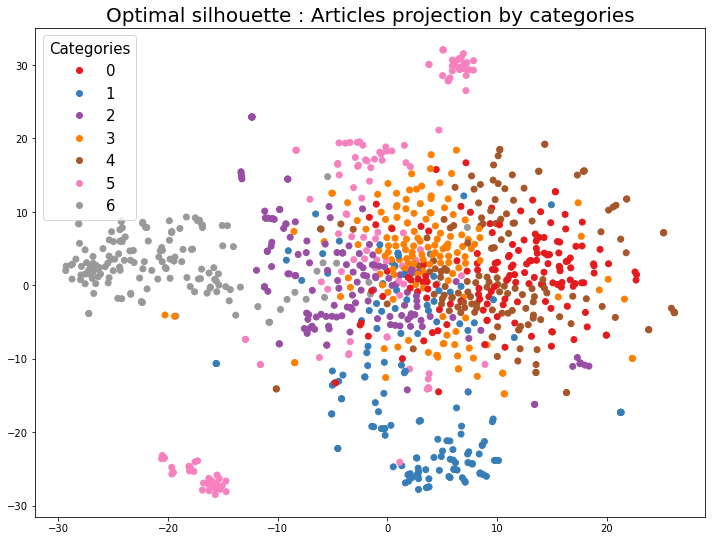

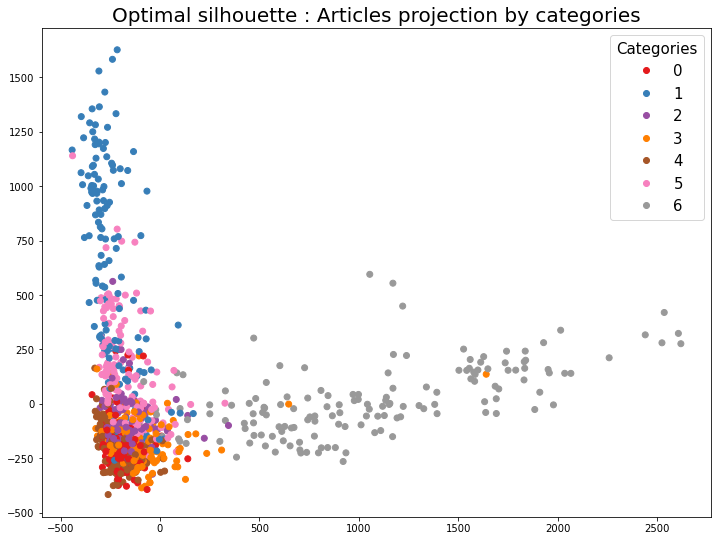

In [6]:
# Display TSNE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
TSNE_visu(features_mat, labels_df.values.ravel(), ax)
ax.set_title('Optimal silhouette : Articles projection by categories', fontsize=20)
plt.show()

# Display PCA
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
PCA_visu(features_mat, labels_df.values.ravel(), ax)
ax.set_title('Optimal silhouette : Articles projection by categories', fontsize=20)
plt.show()

# Faire avec texte et image

In [33]:
data_T0 = pd.read_csv(
    "Flipkart/flipkart_com-ecommerce_sample_1050.csv", index_col=['uniq_id'])

data_T = pd.DataFrame(
    data_T0[['image', 'product_category_tree', 'description']])

In [34]:
from nltk.tokenize import word_tokenize

def tokenizer_fct(_sentence):  # function to tokenize a sentence
    sentence_clean = _sentence.replace('-', ' ').replace('+', ' ')\
        .replace('/', ' ').replace('#', ' ').replace('.', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

def lower_fct(list_words):  # lower case et alpha
    lw = [w.lower() for w in list_words]
    return lw

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_lower_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_fct(word_tokens)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data_T['description_lower'] = data_T0['description'].apply(
    lambda x: transform_lower_fct(x))

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vec = TfidfVectorizer(stop_words='english',
                         min_df=71, 
                         max_df=300, 
                         ngram_range=(2, 2))
data_transform = tf_vec.fit_transform(data_T['description_lower'])

print(data_transform.todense().shape)

print(features_mat.shape)


# Faire PCA sur feature image pour avoir autant de feature texte VS image

# Faire une normalisation en divisant par le nombre de feature et ça devrait marcher sur la PCA

(1050, 24)
(1050, 100352)


In [ ]:
# Display TSNE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
TSNE_visu(features_mat, labels_df.values.ravel(), ax)
ax.set_title('Optimal silhouette : Articles projection by categories', fontsize=20)
plt.show()

# Display PCA
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
PCA_visu(features_mat, labels_df.values.ravel(), ax)
ax.set_title('Optimal silhouette : Articles projection by categories', fontsize=20)
plt.show()